# LST Planetary Variables from Subscriptions API


The city of Phoenix, Arizona experiences extreme heat and significant challenges related to the Urban Heat Island (UHI) effect. The intensity of heat and UHI impacts can be influenced by various factors such as land cover, infrastructure, and socioeconomic conditions. It is indeed crucial to address these challenges and develop strategies to mitigate the adverse effects of extreme heat in such areas.

When analyzing LST data and identifying anomalies in South Phoenix, a higher-resolution dataset like 100m can help capture localized temperature variations and detect hotspots more accurately. This can assist in pinpointing specific areas within South Phoenix that exhibit exceptionally high LST values, indicating intense UHI effects.

By identifying these hotspots, policymakers, urban planners, and communities can focus their efforts on implementing targeted interventions and mitigation measures to reduce the heat island effect and improve the thermal comfort and resilience of South Phoenix. Strategies may include increasing green spaces, implementing cool roofs, improving urban design for better ventilation, and promoting heat mitigation initiatives at the community level.

(See Surface urban heat island (SUHI) effect J. A. Voogt and T. R. Oke, “Thermal remote sensing of urban climates,” Remote Sens. Environ., vol. 86, no. 3, pp. 370–384, Aug. 2003.)


## Planet API Authentication

The Planet API uses Basic HTTP Authentication and requires that you have a Planet API key. Once you're signed up, you can find your API key in your [account settings](https://www.planet.com/account). Only one value is needed, so instead of using a username and password, you authenticate by setting `username` to your API key.

You could pass the API key as a variable in your code, but doing so makes it easy for others to see your key--not a good privacy and security practice. So the Python example, below, presumes you've stored your API key in a `.env` file at the root of your project.

You create a `.env` file and place your API string there:

```
PL_API_KEY = "[The API string from the My Settings section of your Planet Account page]"
```

Now, you are ready to pull your API key into your Python code without exposing it in the code. Assuming your Python file is in the same directory as your `.env` file, you import the dotenv package and call `dotenv_values(".env")`.

## Drought in the Horn of Africa

[Using Planetary Forensics To Visualize Historic Drought In The Horn Of Africa](https://www.planet.com/pulse/using-planetary-forensics-to-visualize-historic-drought-in-the-horn-of-africa/) discusses a use of geospatial data analysis that visualizes the historic drought in the Horn of Africa.

To assess the severity of the drought, “planetary forensics” techniques are employed, such as measuring the moisture content in the soil. The Soil Water Content data provided by Planet offers near-real-time measurements of soil moisture. This data is more accurate than traditional models based solely on precipitation totals because it accounts for water loss due to evaporation and surface runoff. By using satellite data, the soil water content measurements create visualizations that depict water levels and fluctuations over time, providing a granular understanding of the effects of dryness.

While the data in the article uses climatology methods to look back at the data, in this example we create a subscription, pull the results as CSV data, and then simply plot the mean, pointing out an increasing number of days when the soil water content was three standard deviations below the mean.



In [14]:
from io import StringIO
import datetime as datetime

from dotenv import dotenv_values
import requests
from requests.auth import HTTPBasicAuth
import json

from shapely.geometry import shape
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd


In [3]:
# Get your Planet API Key from an environment variable
DOT_ENV_VALS = dotenv_values(".env")

# Your Planet API Key 
API_KEY = DOT_ENV_VALS["PL_API_KEY"] 

# Planet's Subscriptions API base URL for making restFUL requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

In [4]:
# confirm that the API key is valid
auth = HTTPBasicAuth(API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
response

<Response [200]>

In [5]:
# Get number of subscriptions you have currently
subscriptions = response.json()['subscriptions']
len(subscriptions)

20

## Creating a Planetary Variables Subscription with the Subscriptions API

To create a subscription using the Client, provide a JSON request object that includes required information such as source type, geojson, and others (link to the docs).

### Create your JSON subscription description object

Is your area of interest (AOI) inside the area of access (AOA) for your contract with Planet? You can compare the two geojson objects using Shapely.

In [6]:
# Area of Interest (AOI) - Phoneix, AZ
AOI = {
    "type": "Polygon",
    "coordinates": [[[-112.448776,33.23932599999999],
                        [-112.448776,33.95612],
                        [-111.72052,33.95612],
                        [-111.72052,33.23932599999999],
                        [-112.448776,33.23932599999999]]]
      }

# Area of Access (AOA) - US
AOA = {
    "type": "Polygon",
    "coordinates": [[[ -126.9504, 46.5531 ],
                        [ -54.1833, 46.7628 ],
                        [ -77.8798, 24.3246 ],
                        [ -94.6561, 23.9051 ],
                        [ -124.2242, 34.1806 ],
                        [ -126.9504, 46.5531 ]]]
      }

# Determine if the AOI is inside the AOA
def is_inside(AOI, AOA):
    smaller_shape = shape(AOI)
    larger_shape = shape(AOA)
    
    return smaller_shape.within(larger_shape)

result = is_inside(AOI, AOA)
print(result)  # True


True


In [8]:
# Create a new subscription JSON object
subscription_desc = {
   "name": "Phoenix, AZ 5 yrs LST-AMSR2_V1.0_100",
   "source": {
       "type": "land_surface_temperature",
       "parameters": {
           "id": "LST-AMSR2_V1.0_100",
           "start_time": "2018-05-15T00:00:00Z",
           "end_time": "2023-05-15T00:00:00Z",
           "geometry": {
               "coordinates": [[[-112.448776,33.23932599999999],
                        [-112.448776,33.95612],
                        [-111.72052,33.95612],
                        [-111.72052,33.23932599999999],
                        [-112.448776,33.23932599999999]]],
               "type": "Polygon"
           }
       }
   }
}

In [9]:
# View the JSON object
subscription_desc

{'name': 'Phoenix, AZ 5 yrs LST-AMSR2_V1.0_100',
 'source': {'type': 'land_surface_temperature',
  'parameters': {'id': 'LST-AMSR2_V1.0_100',
   'start_time': '2018-05-15T00:00:00Z',
   'end_time': '2023-05-15T00:00:00Z',
   'geometry': {'coordinates': [[[-112.448776, 33.23932599999999],
      [-112.448776, 33.95612],
      [-111.72052, 33.95612],
      [-111.72052, 33.23932599999999],
      [-112.448776, 33.23932599999999]]],
    'type': 'Polygon'}}}}

### Create a subscription using your JSON subscription description object


In [12]:
# set content type to json
headers = {'content-type': 'application/json'}

# create a subscription
def subscribe_pv(subscription_desc, auth, headers):
    response = requests.post(BASE_URL, data=json.dumps(subscription_desc), auth=auth, headers=headers)
    print(response)
    subscription_id = response.json()['id']
    print(subscription_id)
    subscription_url = BASE_URL + '/' + subscription_id
    return subscription_url

pv_subscription = subscribe_pv(subscription_desc, auth, headers)

<Response [200]>
595c1e13-7d04-4e41-b21b-a0396708c1af


## Using the data from Planet

### Get the subscription

Here we check the status of the subscription we created. When it has the status `completed`, it'll be delivered to the bucket, above.


In [10]:
# Get the subscription ID - GCP bucket directory name where the data will be delivered
sub_id = requests.get(pv_subscription, auth=auth).json()['id']
# sub_id = "595c1e13-7d04-4e41-b21b-a0396708c1af"

# Use sub_id to get the subscription state
def get_sub_status(sub_id, auth):
    sub_url = BASE_URL + '/' + sub_id
    sub_status = requests.get(sub_url, auth=auth).json()['status']
    return sub_status

# Note: Running the subscription may take a while depending 
# on the size of your AOI and the time range.
sub_status = get_sub_status(sub_id, auth)
sub_status


'completed'

Use the pandas library to read the CSV data into a DataFrame called df. Filter only valid data is retained in the DataFrame for further analysis or processing.

Read more about the different state of [Subscription Status](https://developers.planet.com/docs/subscriptions/#subscription-status).

In [ ]:
# Retrieve the resulting data in CSV format. 
# sub_id = requests.get(pv_subscription, auth=auth).json()['id']
resultsCSV = requests.get(f"{BASE_URL}/{sub_id}/results?format=csv", auth=auth)

# resultsCSV.text
# read the CSV data into a text file
with open('results.csv', 'w') as f:
    f.write(resultsCSV.text)

# Read CSV Data
df = pd.read_csv(StringIO(resultsCSV.text), parse_dates=["item_datetime", "local_solar_time"])

# Filter by valid data only
df = df[df["lst.band-1.valid_percent"].notnull()]
df = df[df["lst.band-1.valid_percent"] > 0]
df = df[df["status"] != 'QUEUED']

df.head()

,id,item_datetime,status,created,updated,errors,item_id,local_solar_time,lst.band-1.mean,lst.band-1.valid_percent,source_id
1,a84b0b1c-d327-4c1c-bb2f-7c5cf6654820,2018-05-15 20:30:00+00:00,SUCCESS,2023-05-13T21:38:13.629538Z,2023-05-13T21:38:13.629538Z,{},LST-AMSR2_V1.0_100_2018-05-15T1330,2018-05-15 13:30:00,325.39,99,LST-AMSR2_V1.0_100
5,e3612ee5-4fd9-4144-b678-78ceae7de403,2018-05-17 20:30:00+00:00,SUCCESS,2023-05-13T21:38:17.943891Z,2023-05-13T21:38:17.943892Z,{},LST-AMSR2_V1.0_100_2018-05-17T1330,2018-05-17 13:30:00,325.24,99,LST-AMSR2_V1.0_100
7,6d3318c1-1fec-440d-b9c8-05d0644cb541,2018-05-18 20:30:00+00:00,SUCCESS,2023-05-13T21:38:20.425406Z,2023-05-13T21:38:20.425406Z,{},LST-AMSR2_V1.0_100_2018-05-18T1330,2018-05-18 13:30:00,325.18,99,LST-AMSR2_V1.0_100
9,8b230b3d-4cba-4281-8c63-a084de6f44bc,2018-05-19 20:30:00+00:00,SUCCESS,2023-05-13T21:38:22.896786Z,2023-05-13T21:38:22.896786Z,{},LST-AMSR2_V1.0_100_2018-05-19T1330,2018-05-19 13:30:00,324.81,99,LST-AMSR2_V1.0_100
11,f757781a-f3af-4196-a7be-9d0f8410fffe,2018-05-20 20:30:00+00:00,SUCCESS,2023-05-13T21:38:25.54157Z,2023-05-13T21:38:25.54157Z,{},LST-AMSR2_V1.0_100_2018-05-20T1330,2018-05-20 13:30:00,325.13,99,LST-AMSR2_V1.0_100


Next, plot the data.

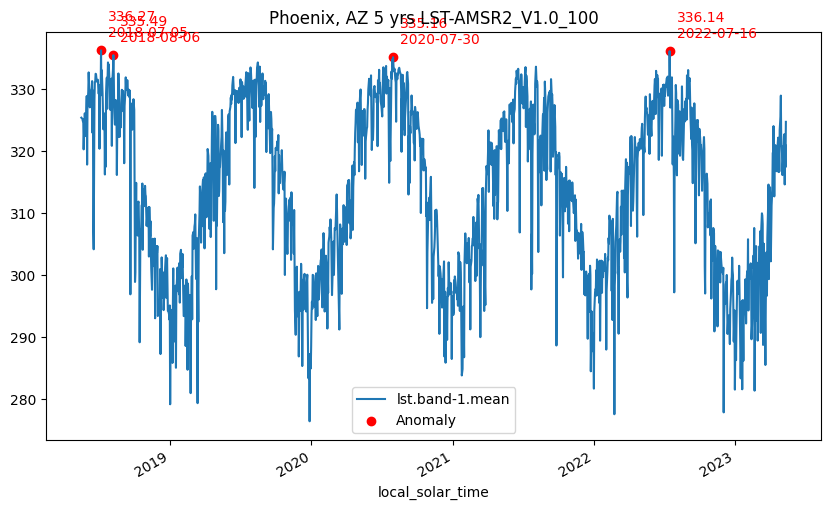

In [16]:
# 330K ≈ 134.33°F

# Calculate the mean and standard deviation
mean_value = df["lst.band-1.mean"].mean()
std_dev = df["lst.band-1.mean"].std()

# Define the threshold as 3 standard deviations below the mean
# 350K ≈ 134.33°F
anomaly_threshold = 335

# Find anomalies
anomalies = df[df["lst.band-1.mean"] > anomaly_threshold]
anomalies

# Plot the line chart
df.title = subscription_desc["name"]

ax = df.plot.line('local_solar_time', 'lst.band-1.mean', title=df.title, figsize=(10, 6))

# Scatter plot for anomalies
ax.scatter(anomalies.local_solar_time, anomalies["lst.band-1.mean"], color='red', label='Anomaly')

# Add labels to the anomalies
for index, row in anomalies.iterrows():
    ax.annotate(f'{row["lst.band-1.mean"]}\n{row["local_solar_time"].strftime("%Y-%m-%d")}', (row['local_solar_time'], row['lst.band-1.mean']), 
                xytext=(5, 10), textcoords='offset points', color='red')

# Display the plot
plt.legend()
plt.show()

